In [1]:
!apt-get update

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz

In [4]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [5]:
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [7]:
import findspark
findspark.init()

In [8]:
!wget -O veh -q https://data.cityofnewyork.us/api/views/bm4k-52h4/rows.csv?accessType=DOWNLOAD


In [9]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -y ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-05-07 15:34:02--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.2.52, 3.216.86.20, 34.235.106.23, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.2.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  13.5MB/s    in 1.0s    

2021-05-07 15:34:04 (13.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test co

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Collision")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [11]:
col=spark.read.option("header",True).csv("./veh",inferSchema=True);

In [12]:
col.cache()

DataFrame[UNIQUE_ID: int, COLLISION_ID: int, CRASH_DATE: string, CRASH_TIME: string, VEHICLE_ID: string, STATE_REGISTRATION: string, VEHICLE_TYPE: string, VEHICLE_MAKE: string, VEHICLE_MODEL: string, VEHICLE_YEAR: int, TRAVEL_DIRECTION: string, VEHICLE_OCCUPANTS: int, DRIVER_SEX: string, DRIVER_LICENSE_STATUS: string, DRIVER_LICENSE_JURISDICTION: string, PRE_CRASH: string, POINT_OF_IMPACT: string, VEHICLE_DAMAGE: string, VEHICLE_DAMAGE_1: string, VEHICLE_DAMAGE_2: string, VEHICLE_DAMAGE_3: string, PUBLIC_PROPERTY_DAMAGE: string, PUBLIC_PROPERTY_DAMAGE_TYPE: string, CONTRIBUTING_FACTOR_1: string, CONTRIBUTING_FACTOR_2: string]

In [13]:
col.count() - col.distinct().count()

0

In [14]:
len(col.columns) 

25

In [15]:
col.printSchema() 

root
 |-- UNIQUE_ID: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- CRASH_TIME: string (nullable = true)
 |-- VEHICLE_ID: string (nullable = true)
 |-- STATE_REGISTRATION: string (nullable = true)
 |-- VEHICLE_TYPE: string (nullable = true)
 |-- VEHICLE_MAKE: string (nullable = true)
 |-- VEHICLE_MODEL: string (nullable = true)
 |-- VEHICLE_YEAR: integer (nullable = true)
 |-- TRAVEL_DIRECTION: string (nullable = true)
 |-- VEHICLE_OCCUPANTS: integer (nullable = true)
 |-- DRIVER_SEX: string (nullable = true)
 |-- DRIVER_LICENSE_STATUS: string (nullable = true)
 |-- DRIVER_LICENSE_JURISDICTION: string (nullable = true)
 |-- PRE_CRASH: string (nullable = true)
 |-- POINT_OF_IMPACT: string (nullable = true)
 |-- VEHICLE_DAMAGE: string (nullable = true)
 |-- VEHICLE_DAMAGE_1: string (nullable = true)
 |-- VEHICLE_DAMAGE_2: string (nullable = true)
 |-- VEHICLE_DAMAGE_3: string (nullable = true)
 |-- PUBLIC_PROPERTY_DAM

In [16]:
col.select("UNIQUE_ID").distinct().count()-col.select("COLLISION_ID").distinct().count()

1784711

In [17]:
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_date
import pandas as pd

col= col.withColumn('CRASH_TIME',to_timestamp(col["CRASH_TIME"], 'H:mm'))


In [18]:
col= col.withColumn('CRASH_DATE',to_date(col["CRASH_DATE"], 'MM/dd/yyyy'))

In [19]:
col=col.fillna(value="NOT PROVIDED",subset=["PUBLIC_PROPERTY_DAMAGE"])

In [20]:
col=col.fillna(value="NOT PROVIDED",subset=["PUBLIC_PROPERTY_DAMAGE"])

In [21]:

col=col.fillna(value="NOT PROVIDED",subset=["CONTRIBUTING_FACTOR_1"])

In [22]:

col=col.fillna(value="NOT PROVIDED",subset=["CONTRIBUTING_FACTOR_2"])

In [23]:
col=col.fillna(value="NOT PROVIDED",subset=["PUBLIC_PROPERTY_DAMAGE"])

In [24]:
col.select("VEHICLE_TYPE").distinct().show(20);

+------------+
|VEHICLE_TYPE|
+------------+
|       trail|
|        ELEC|
|         BOX|
|       PASS-|
|       USP M|
|       CONVE|
|       ASTRO|
|         NIU|
|  HORSE CARR|
|  truck trai|
|  MOTOR DIRT|
|  School Bus|
|         TRK|
|       NYC S|
|       GOVER|
|       FireT|
|         VAM|
|        BOAT|
|       PETER|
|    FLAT BED|
+------------+
only showing top 20 rows



In [25]:
col.createOrReplaceTempView("vehicle");


In [26]:
v_damage=spark.sql("select VEHICLE_TYPE, count(unique_id) AS count from vehicle group by VEHICLE_TYPE having VEHICLE_TYPE is not null and VEHICLE_TYPE != 'UNKNOWN' order by count desc limit 10")     

In [27]:
v_damage.show()

+--------------------+------+
|        VEHICLE_TYPE| count|
+--------------------+------+
|               Sedan|801259|
|   PASSENGER VEHICLE|770756|
|Station Wagon/Spo...|649626|
|SPORT UTILITY / S...|337927|
|                Taxi| 80210|
|          4 dr sedan| 73370|
|                TAXI| 60785|
|       Pick-up Truck| 56580|
|                 VAN| 49720|
|               OTHER| 45954|
+--------------------+------+



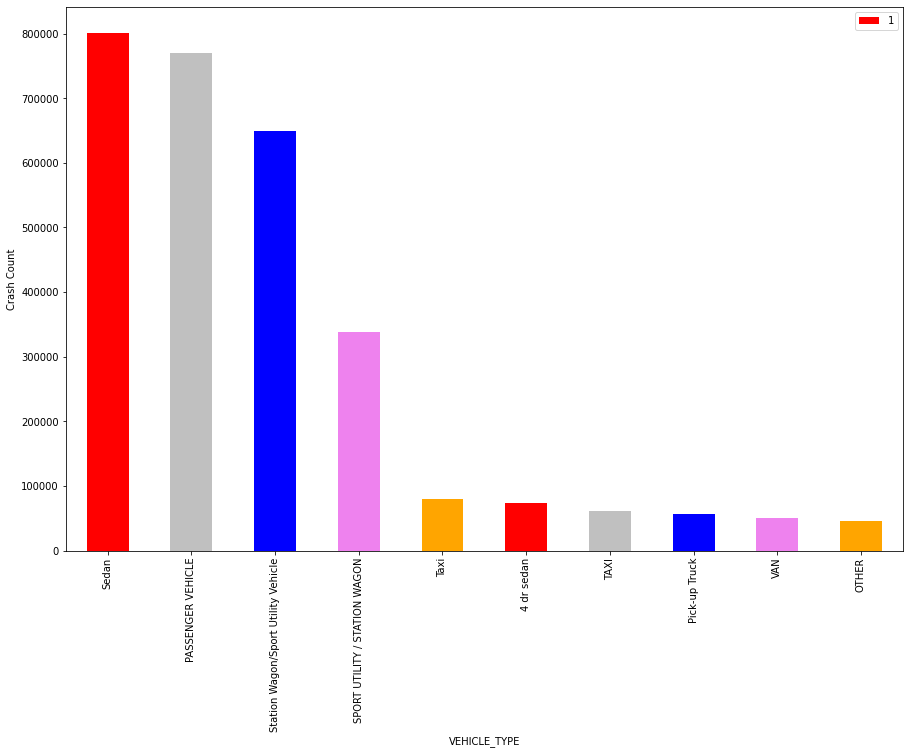

In [28]:
pd.DataFrame(v_damage.collect()).plot.bar(x=0,y=1,color=["red","silver","blue","violet","orange"],figsize=(15,10)
                                                                                                          ,xlabel="VEHICLE_TYPE",ylabel="Crash Count"      )


In [29]:
driving_liscence=spark.sql("select DRIVER_LICENSE_STATUS ,count(unique_id) AS count from vehicle group by DRIVER_LICENSE_STATUS having DRIVER_LICENSE_STATUS is not null and DRIVER_LICENSE_STATUS != 'UNKNOWN' order by count desc")     

In [30]:
driving_liscence=pd.DataFrame(driving_liscence.collect());
driving_liscence=driving_liscence.set_index(0)
driving_liscence

,1
0,
Licensed,1465770
Unlicensed,24770
Permit,10234


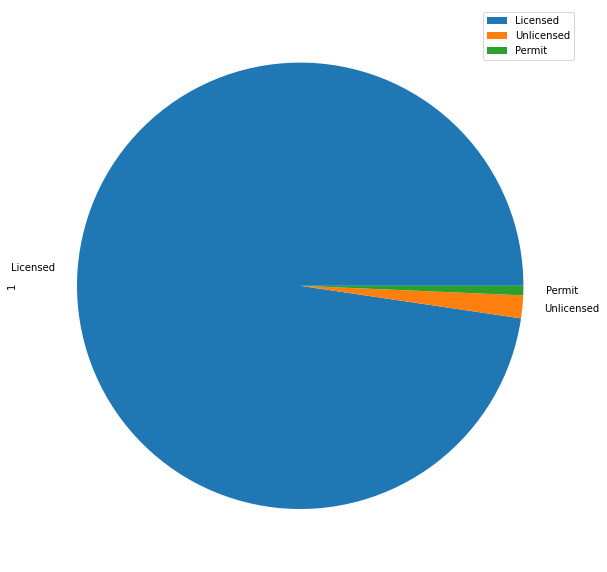

In [31]:
driving_liscence.plot.pie(y=1, figsize=(10, 15))

In [32]:
col.select("VEHICLE_YEAR").distinct().show()

+------------+
|VEHICLE_YEAR|
+------------+
|        1959|
|        7993|
|        1990|
|        2811|
|        2996|
|        3000|
|        2711|
|        2821|
|        1975|
|        2025|
|        2096|
|        1977|
|        2914|
|        2027|
|        3028|
|        2200|
|        4321|
|        2003|
|        4992|
|        2007|
+------------+
only showing top 20 rows



In [33]:
reasonsForAccidents=spark.sql("select PRE_CRASH,count(unique_id) AS count from vehicle group by PRE_CRASH having PRE_CRASH is not null and PRE_CRASH != 'Other*' order by count desc limit 5")     

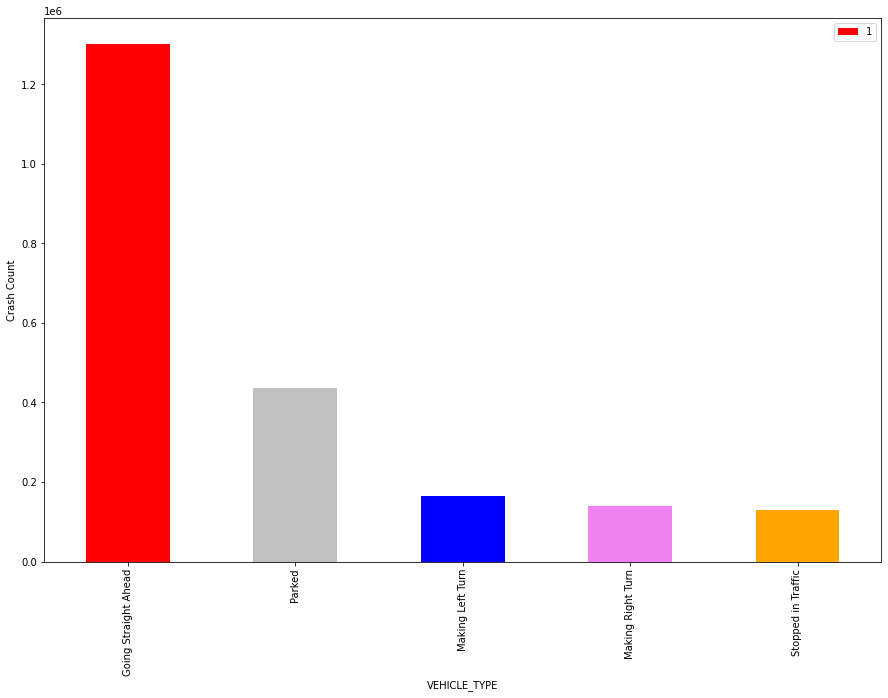

In [34]:
pd.DataFrame(reasonsForAccidents.collect()).plot.bar(x=0,y=1,color=["red","silver","blue","violet","orange"],figsize=(15,10)
                                                                                                          ,xlabel="VEHICLE_TYPE",ylabel="Crash Count"      )


In [35]:
reasonsForAccidents=spark.sql("select PRE_CRASH,count(unique_id) AS count from vehicle group by PRE_CRASH having PRE_CRASH is not null and PRE_CRASH != 'Other*' order by count desc")     

In [36]:
col.select("DRIVER_LICENSE_STATUS").distinct().show(10);

+---------------------+
|DRIVER_LICENSE_STATUS|
+---------------------+
|                 null|
|           Unlicensed|
|               Permit|
|             Licensed|
+---------------------+



In [37]:
reasonsForAccidentsPublicProperty=spark.sql("select PRE_CRASH as reason,count(unique_id) AS count from vehicle where PUBLIC_PROPERTY_DAMAGE='Y' group by PRE_CRASH having PRE_CRASH is not null and PRE_CRASH != 'Other*' order by count desc")     

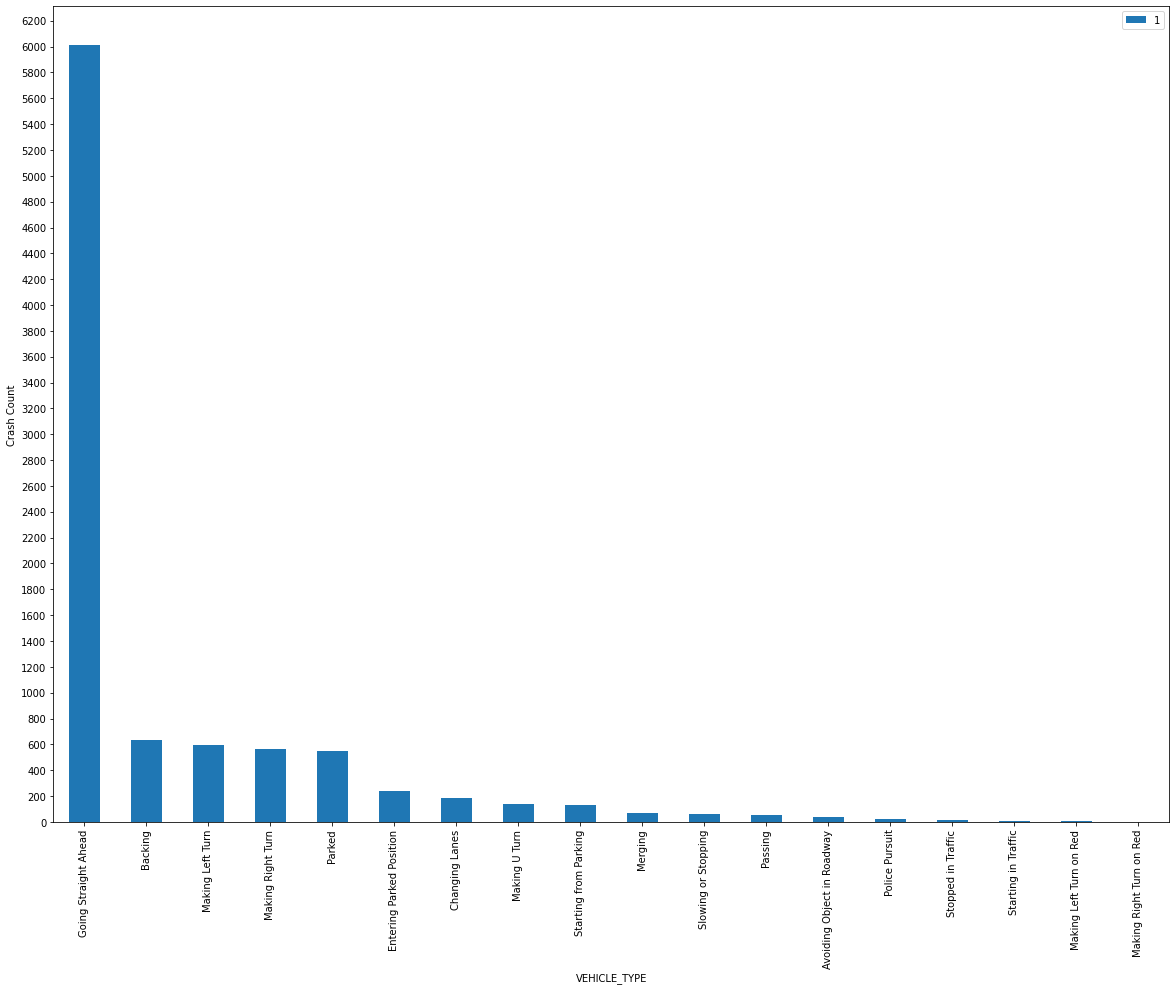

In [38]:
pd.DataFrame(reasonsForAccidentsPublicProperty.collect()).plot.bar(yticks=range(0,6300,200),x=0,y=1,figsize=(20,15)
                                                                                                          ,xlabel="VEHICLE_TYPE",ylabel="Crash Count"      )


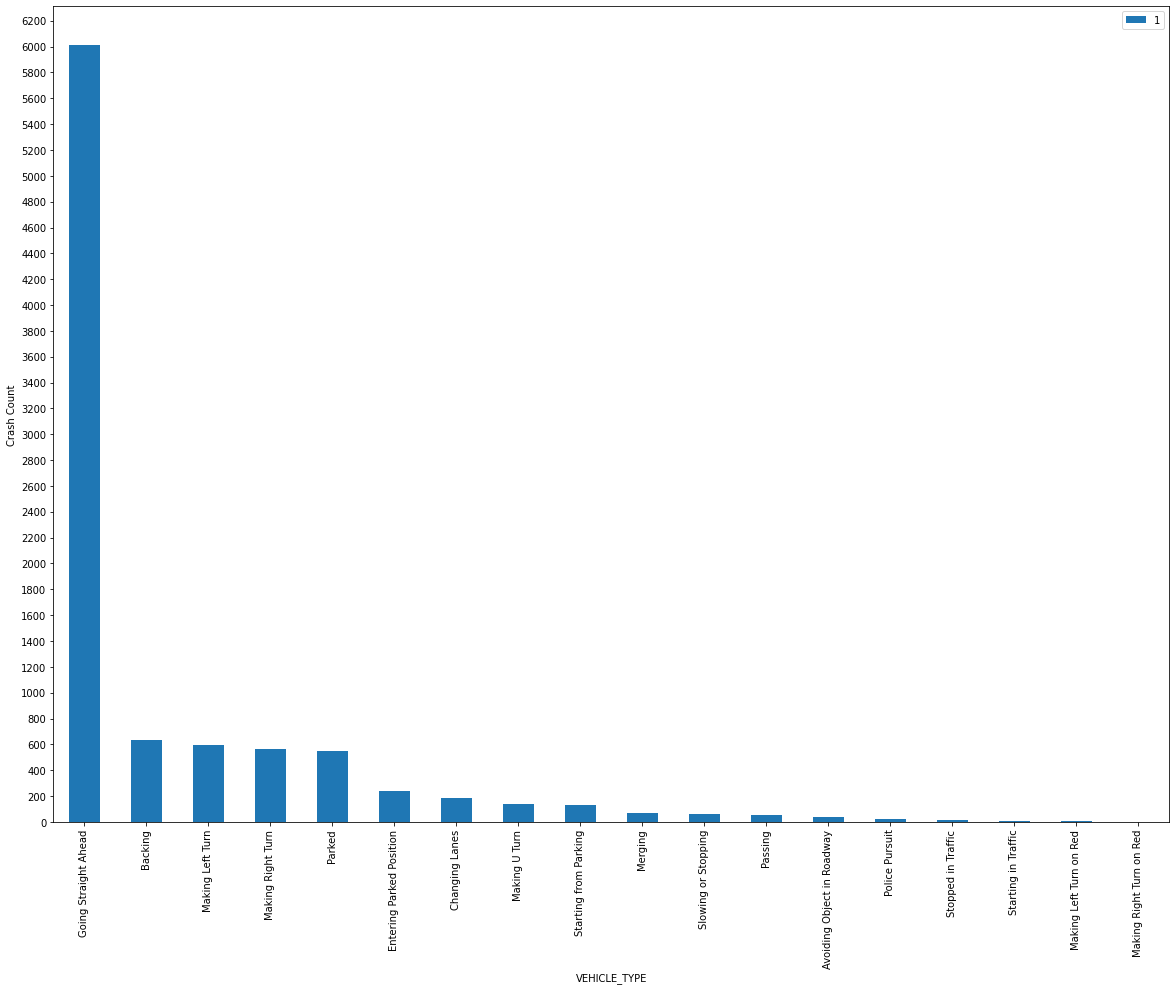

In [39]:
pd.DataFrame(reasonsForAccidentsPublicProperty.collect()).plot.bar(yticks=range(0,6300,200),x=0,y=1,figsize=(20,15)
                                                                                                          ,xlabel="VEHICLE_TYPE",ylabel="Crash Count"      )


In [40]:
col.select("PUBLIC_PROPERTY_DAMAGE_TYPE").distinct().show()

+---------------------------+
|PUBLIC_PROPERTY_DAMAGE_TYPE|
+---------------------------+
|       THREE ORANGE CONS...|
|                   BUS STOP|
|       FENCING DIVIDING ...|
|       POLICE/FIRE CALL ...|
|       LANDSCAPE AND FRO...|
|       CEMENT PILLAR INS...|
|       LAMP POST, BRICK ...|
|       NEWS STAND BEARS ...|
|       BLACK METAL FENCE...|
|       BLACK LIGHT POLE ...|
|       GRASS BETWEEN CUR...|
|       DAMAGE TO SUBWAY ...|
|       DAMAGE TO CAMERA ...|
|       THE FENCE/WALL OF...|
|        BRICK RETAINER WALL|
|       GATE OF 8 ROCKAWA...|
|       CHAIN LINK FENCE ...|
|       AT T/P/O D1 DID C...|
|       FENCE (PARKS DEPA...|
|       MONA<quote>S CUISINE|
+---------------------------+
only showing top 20 rows



In [41]:
!pip install chord

In [42]:
import chord
cordDig=spark.sql("select DRIVER_LICENSE_STATUS,PRE_CRASH,count(unique_id) from vehicle group by PRE_CRASH,DRIVER_LICENSE_STATUS having PRE_CRASH is not null");    

In [43]:
# Contributing factors for Public Property damage.

In [44]:
FactorsForAccidentsPublicProperty=spark.sql("select CONTRIBUTING_FACTOR_1 as factor,count(unique_id) AS count from vehicle where PUBLIC_PROPERTY_DAMAGE='Y' group by factor  having factor!='Unspecified' order by count desc limit 5")     

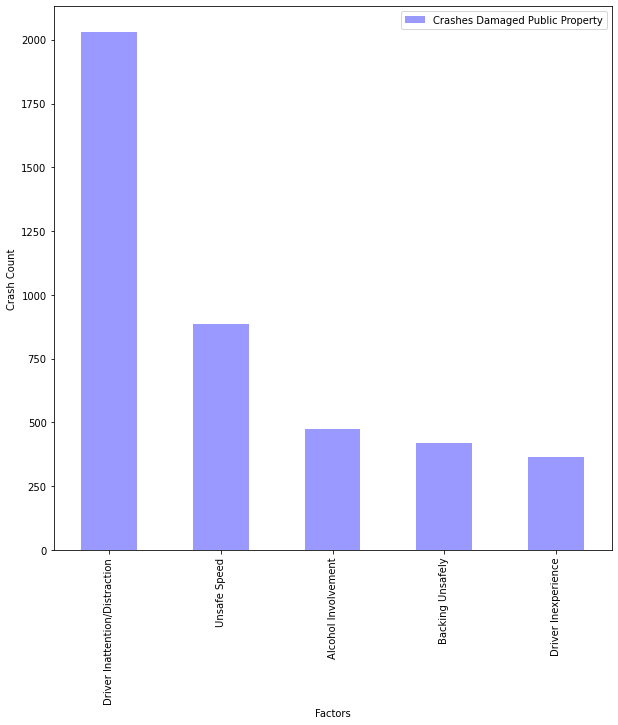

In [45]:
pd.DataFrame(FactorsForAccidentsPublicProperty.collect()).plot.bar(color=["#9999ff"],x=0,y=1,figsize=(10,10)
                                                                                                          ,xlabel="Factors",ylabel="Crash Count",label='Crashes Damaged Public Property')


In [46]:

TypesForAccidentsPublicProperty=spark.sql("select PUBLIC_PROPERTY_DAMAGE_TYPE as type,count(unique_id) AS count from vehicle group by type having type is not null order by count desc limit 5")     

In [47]:
TypesForAccidentsPublicProperty.show();

+------------+-----+
|        type|count|
+------------+-----+
|       FENCE|  554|
|  LIGHT POLE|  315|
|UTILITY POLE|  195|
|FIRE HYDRANT|  169|
|        TREE|  138|
+------------+-----+



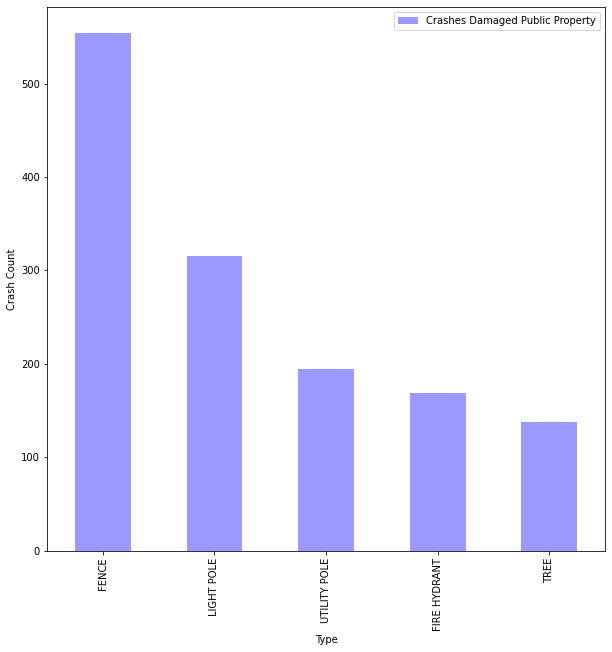

In [48]:
pd.DataFrame(TypesForAccidentsPublicProperty.collect()).plot.bar(color=["#9999ff"],x=0,y=1,figsize=(10,10)
                                                                                                          ,xlabel="Type",ylabel="Crash Count",label='Crashes Damaged Public Property')


In [49]:
#POINT_OF_IMPACT : Top 5 point of Impacts.
top5impacts=spark.sql("select POINT_OF_IMPACT as impact,count(unique_id) AS count from vehicle group by impact having impact is not null order by count desc limit 5")     




In [50]:
top5impacts.show()

+--------------------+------+
|              impact| count|
+--------------------+------+
|    Center Front End|309123|
|   Left Front Bumper|238516|
|     Center Back End|232245|
|  Right Front Bumper|212700|
|Right Front Quart...|142785|
+--------------------+------+



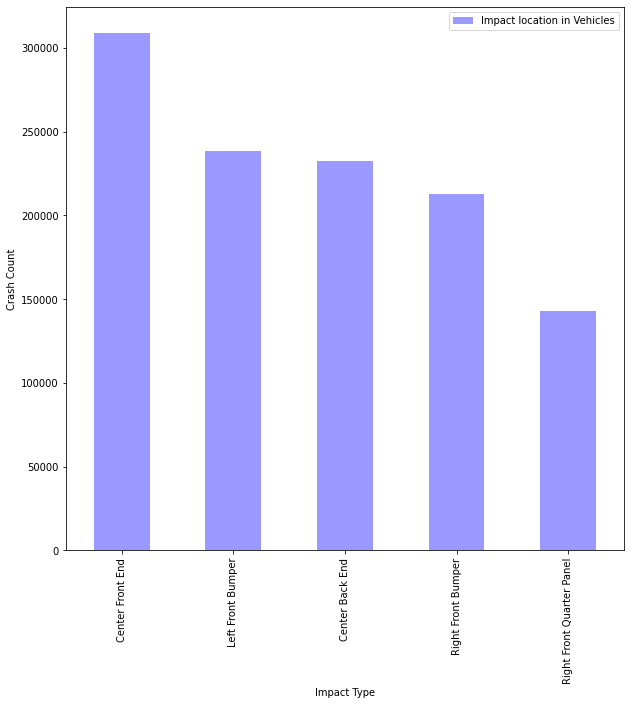

In [51]:
pd.DataFrame(top5impacts.collect()).plot.bar(color=["#9999ff"],x=0,y=1,figsize=(10,10)
                                                                                                          ,xlabel="Impact Type",ylabel="Crash Count",label='Impact location in Vehicles')
